# Baroclinic Potential Vorticity Analysis, Divergence, and Winds

Classic baroclinic potential vorticity plot at 250 hPa using GFS analysis file.

This example uses example data from the GFS analysis for 12 UTC
31 October 2016 and uses xarray as the main read source with using
MetPy to calculate the baroclinic potential vorticity, divergence and
wind speed with geographic plotting using Cartopy for a CONUS view of
the 250-hPa surface with divergence and wind barbs.

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr

The following code reads the example data using the xarray open_dataset
function and prints the coordinate values that are associated with the
various variables contained within the file.

In [2]:
ds = xr.open_dataset('../data/GFS_20101026_1200.nc')
print(ds)

<xarray.Dataset>
Dimensions:                                  (height_above_ground: 1, height_above_ground1: 1, isobaric3: 26, isobaric5: 25, lat: 361, lon: 720, time: 1)
Coordinates:
  * time                                     (time) datetime64[ns] 2010-10-26T12:00:00 ...
  * isobaric3                                (isobaric3) float32 1000.0 ...
  * lat                                      (lat) float32 90.0 89.5 89.0 ...
  * lon                                      (lon) float32 0.0 0.5 1.0 1.5 ...
  * height_above_ground1                     (height_above_ground1) float32 10.0
  * isobaric5                                (isobaric5) float32 1000.0 ...
  * height_above_ground                      (height_above_ground) float32 2.0
Data variables:
    u-component_of_wind_isobaric             (time, isobaric3, lat, lon) float32 ...
    v-component_of_wind_height_above_ground  (time, height_above_ground1, lat, lon) float32 ...
    v-component_of_wind_isobaric             (time, isobari

## Data Retrieval

This code retrieves the necessary data from the file and completes some
smoothing of the temperature, and wind fields using the SciPy function
gaussian_filter. A nicely formated valid time (vtime) variable
is also created.

In [3]:
# Grab lat/lon values (GFS will be 1D)
lat = ds.lat.data
lon = ds.lon.data

# Set subset slice for the geographic extent of data to limit download
lon_slice = slice(400,701)
lat_slice = slice(10,160)

# Subset lat/lon values
lons = lon[lon_slice]
lats = lat[lat_slice]

# Grab the pressure levels and select the data to be imported
# Need all pressure levels for Temperatures, U and V Wind, and Rel. Humidity
# Smooth with the gaussian filter from scipy
pres = ds['isobaric3'].data[:] * units('Pa')

tmpk_var = ds['Temperature_isobaric'].data[0, :, lat_slice, lon_slice]
tmpk = gaussian_filter(tmpk_var, sigma=1.0) * units.K
thta = mpcalc.potential_temperature(pres[:, None, None], tmpk)

uwnd_var = ds['u-component_of_wind_isobaric'].data[0, :, lat_slice, lon_slice]
vwnd_var = ds['v-component_of_wind_isobaric'].data[0, :, lat_slice, lon_slice]
uwnd = gaussian_filter(uwnd_var, sigma=1.0) * units('m/s')
vwnd = gaussian_filter(vwnd_var, sigma=1.0) * units('m/s')

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

Use MetPy to compute the baroclinic potential vorticity on all isobaric levels and other variables

In [4]:
# Compute dx and dy spacing for use in vorticity calculation
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

# Comput the PV on all isobaric surfaces
pv = mpcalc.potential_vorticity_baroclinic(thta, pres[:, None, None], uwnd, vwnd,
                                           dx[None, :, :], dy[None, :, :],
                                           lats[None, :, None] * units('degrees'))

# Use MetPy to compute the divergence on the pressure surfaces
div = mpcalc.divergence(uwnd, vwnd, dx[None, :, :], dy[None, :, :], dim_order='yx')

# Find the index value for the 250-hPa surface
i250 = list(pres.m).index(((250 * units('hPa')).to(pres.units)).m)

## Map Creation

This next set of code creates the plot and draws contours on a Lambert Conformal
map centered on -100 E longitude. The main view is over the CONUS with
isentropic map with pressure contoured every 50 hPa and relative humidity
colorshaded above 70%.

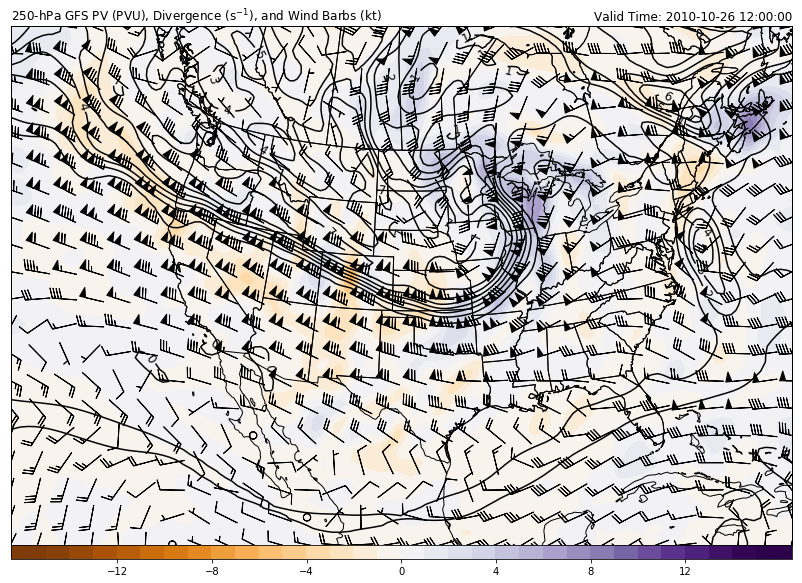

In [5]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14,12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot the contours of PV at 250 hPa, scaling 10^6 every 1 PVU
clevs_pv = np.arange(0, 25, 1)
cs1 = ax.contour(lons, lats, pv[i250]*1e6, clevs_pv, colors='black',
                 transform=datacrs)
plt.clabel(cs1, fmt='%d', fontsize='large')

# Plot the colorfill of divergence, scaled 10^5 every 1 s^1
clevs_div = np.arange(-15, 16, 1)
cs1 = ax.contourf(lons, lats, div[i250]*1e5, clevs_div, cmap=plt.cm.PuOr,
                  extend='both', transform=datacrs)
plt.colorbar(cs1, orientation='horizontal', pad=0, aspect=50, extendrect=True)

# Plot the wind barbs at 250 hPa
ax.barbs(lons, lats, uwnd[i250].to('kt').m, vwnd[i250].to('kt').m, pivot='middle',
         color='black', regrid_shape=20, transform=datacrs)

# Plot some titles to tell people what is on the map
plt.title('250-hPa GFS PV (PVU), Divergence (s$^{-1}$),'
          ' and Wind Barbs (kt)', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

plt.savefig('250_hPa_PV_Analysis.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()